In [437]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import numpy as np
import pyproj
from math import sin, cos, sqrt, atan2, radians

In [438]:
#myproj=pyproj.Proj("""epsg:31287 +units=km +proj=lcc +lat_1=60 +lat_2=70 +lat_0=65 +lon_0=25. +x_0=400000 +y_0=400000 +datum=hermannskogel +no_defs +ellps=bessel +towgs84=577.326,90.129,463.919,5.137,1.474,5.297,2.4232""")
def make_proj(NX, NY, d, center_lon = 25., center_lat = 67., k=1.):
    proj_string = "epsg:31287 +proj=stere +units=km +lon_0={:.3f} lat_0={:.3f} +k_0={:.15f}".format(
        center_lon, center_lat, k)
    myproj=pyproj.Proj(proj_string)
    X=np.arange(NX) - NX/2.
    Y=np.arange(NY) - NY/2.
    XX, YY = np.meshgrid(d * X, d * Y)
    lon,lat=myproj(XX, YY, inverse=True)
    return lon, lat

In [439]:
def calc_distance(lon1, lat1, lon2, lat2):
    # Approximate radius of earth in km
    R = 6373.0
    d = np.zeros(lon1.shape)
    imax, jmax = lon1.shape
    for ii in range(imax):
        for jj in range(jmax):
            dlon = radians(lon2[ii, jj]) - radians(lon1[ii, jj])
            dlat = radians(lat2[ii, jj]) - radians(lat1[ii, jj])

            a = sin(dlat / 2)**2 + cos(radians(lat1[ii, jj])) * cos(radians(lat2[ii, jj])) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            d[ii, jj] = R * c
    return d

Optimizing k for selected projection parameters, maximum 50 iterations:
N = 0, k = 1.0010000000, bias = -0.0063482667
N = 1, k = 1.0020000000, bias = -0.0073355197
N = 2, k = 1.0030000000, bias = -0.0083208172
N = 3, k = 0.9930000000, bias = 0.0016208564
N = 4, k = 0.9863333000, bias = 0.0083599005
N = 5, k = 0.9930000000, bias = 0.0016208564
N = 6, k = 0.9974444889, bias = -0.0028221538
N = 7, k = 0.9930000000, bias = 0.0016208564
N = 8, k = 0.9900369926, bias = 0.0046048890
N = 9, k = 0.9930000000, bias = 0.0016208564
N = 10, k = 0.9949753481, bias = -0.0003587018
N = 11, k = 0.9962922535, bias = -0.0016740823
N = 12, k = 0.9949753481, bias = -0.0003587018
N = 13, k = 0.9940974069, bias = 0.0005201460
N = 14, k = 0.9949753481, bias = -0.0003587018
N = 15, k = 0.9955606453, bias = -0.0009437479
N = 16, k = 0.9949753481, bias = -0.0003587018
N = 17, k = 0.9945851481, bias = 0.0000317109
N = 18, k = 0.9943250135, bias = 0.0002921564
N = 19, k = 0.9945851481, bias = 0.0000317109
N = 20, 

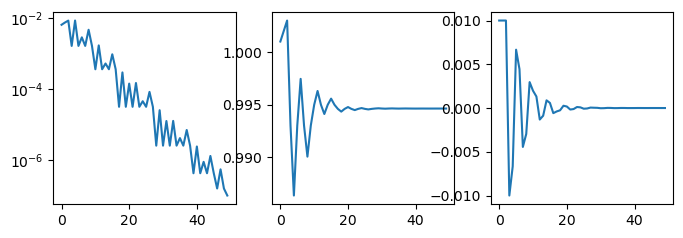

In [496]:
nx = 1500.
ny = nx
d = 1.

lon1, lat1 = make_proj(nx, ny, d=d, k=1.)

xend, yend = lon1.shape

distance11 = calc_distance(lon1[0:xend-2, :], lat1[0:xend-2, :], lon1[1:xend-1, :], lat1[1:xend-1, :])
distance12 = calc_distance(lon1[:, 0:yend-2], lat1[:, 0:yend-2], lon1[:, 1:yend-1], lat1[:, 1:yend-1])
k = 1.0
kstep = 0.01 * d

ks = []
ksteps = []
ds = [1e20]
def err(arr, val, score="bias"):
    """ return score for array and constant val"""
    if score.lower() == "bias":
        return np.mean(arr - val)
    elif score.lower() == "mae":
        return np.mean(np.abs(arr-val))
    elif score.lower() == "rmse":
        return np.sqrt(np.mean(np.square(np.abs(arr-val))))

score = "bias"
maxiter = 50
keep_sign = False
print("Optimizing k for selected projection parameters, maximum {:d} iterations:".format(maxiter))
for ii in range(maxiter):
    if ii > 2:
        if np.abs(ds[-1] - ds[-2]) < 0.0000001 or np.abs(ds[-1]) < 0.0000001:
            # either the last iteration had very little impact or the last score was great
            break
        #print("last 3 values of err: {:.8f} {:.8f}".format(ds[-2], ds[-1]))
        val_change = np.abs(ds[-1]) - np.abs(ds[-2])
        #print("last 3 values of ste: {:.8f} {:.8f}".format(ksteps[-2], ksteps[-1]))
        #print("val change, sign_change", val_change, sign_change)
        #did_sign_change = True if ksteps[-2] * ksteps[-1] < 0. else False
        #did_get_better = True if np.abs(ds[-1]) < np.abs(ds[-2]) else False
        #if did_get_better:
        #    kstep *= 0.66667
        #else:
        #    kstep  = -kstep
        kstep = kstep * 0.66667 if np.abs(ds[-1]) < np.abs(ds[-2]) else -kstep
        k += kstep
    else:
        k += 0.1 * kstep # do a small step to get directions first
    lon2, lat2 = make_proj(nx, ny, d=d, k=k)
    distance21 = calc_distance(lon2[0:xend-2, :], lat2[0:xend-2, :], lon2[1:xend-1, :], lat2[1:xend-1, :])
    distance22 = calc_distance(lon2[:, 0:yend-2], lat2[:, 0:yend-2], lon2[:, 1:yend-1], lat2[:, 1:yend-1])
    dbias = 0.5 * (np.mean(distance21) + np.mean(distance22))
    dist_err = 0.5 * (err(distance21, d, score=score) + err(distance22, d, score=score))
    #k += kstep # just keep going for the first iter
    print("N = {:d}, k = {:.10f}, {:s} = {:.10f}".format(ii, k, score, dist_err))
        
    ks.append(k)
    ksteps.append(kstep)
    ds.append(dist_err)
    #print(ds)

print("Using k = {:.10f} for projection.".format(k))

ks = np.array(ks)
ds = np.array(ds)

fig, axs = plt.subplots(1,3, figsize=(8,2.5))
axs[0].plot(np.abs(ds[1::]))
axs[0].set_yscale('log')
axs[1].plot(ks)
axs[2].plot(ksteps)

dist_min_global = np.min(np.array([
    distance11.min(), distance12.min(), distance21.min(), distance22.min()]))
dist_max_global = np.max(np.array([
    distance11.max(), distance12.max(), distance21.max(), distance22.max()]))

print(dist_min_global, dist_max_global)

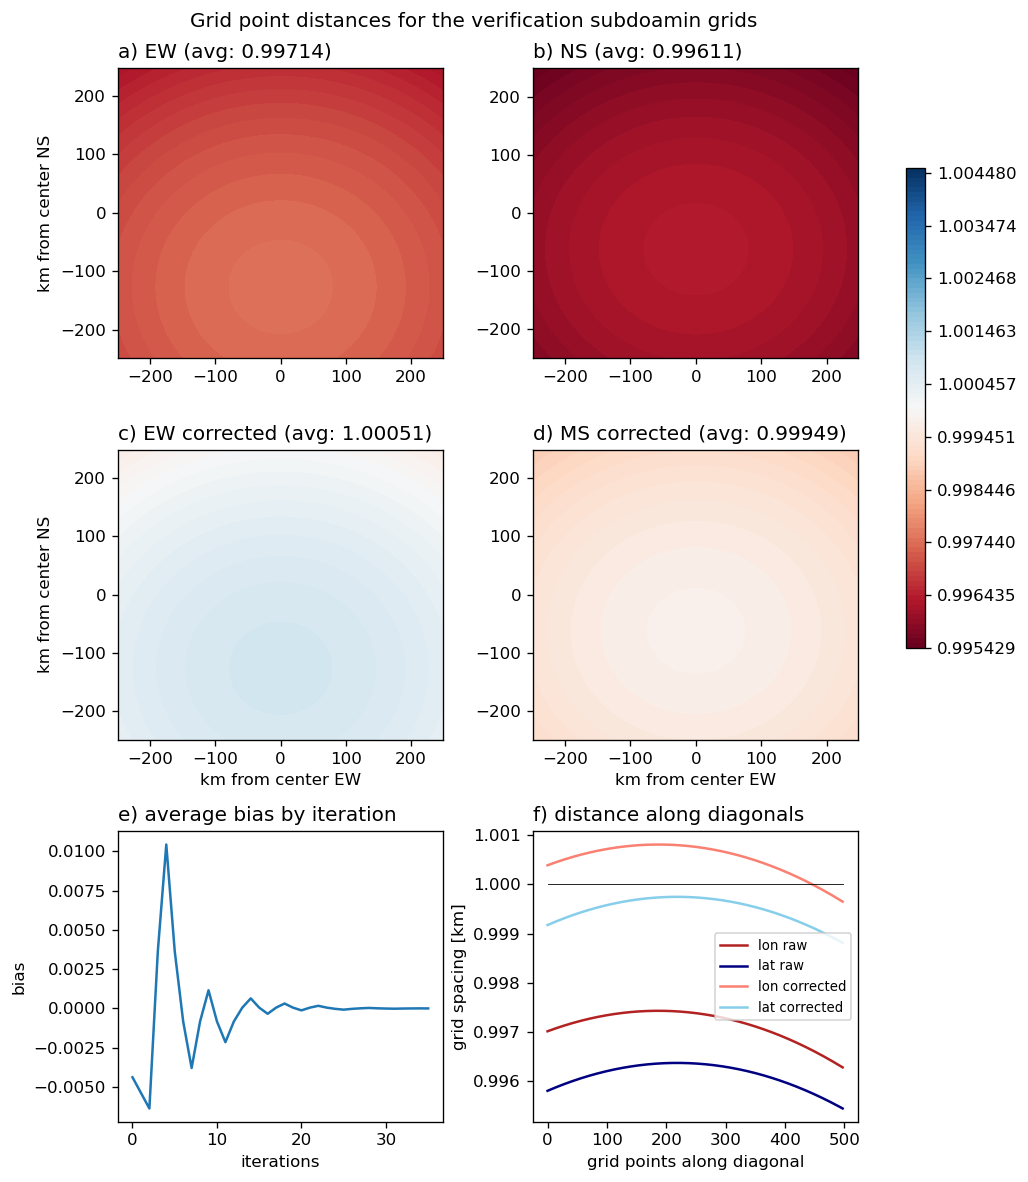

In [485]:
fig, ax = plt.subplots(3,2, figsize=(8,10), dpi=120)

lev_limit = np.max(np.abs(np.array([dist_min_global - d, dist_max_global - d])))
d_lev = 2 * lev_limit / 100.
levels = np.arange(d - lev_limit, d + lev_limit + 0.01 * d_lev, d_lev)

idx_long = d * np.array(range(int(-nx/2), int(nx/2)))
idx_shor = d * np.array(range(int(-nx/2+1), int(nx/2-1)))

c1 = ax[0][0].contourf(idx_long, idx_shor, distance11, levels=levels, cmap="RdBu")
c2 = ax[0][1].contourf(idx_shor, idx_long, distance12, levels=levels, cmap="RdBu")
c3 = ax[1][0].contourf(idx_long, idx_shor, distance21, levels=levels, cmap="RdBu")
c4 = ax[1][1].contourf(idx_shor, idx_long, distance22, levels=levels, cmap="RdBu")
ax[0][0].set_title("a) EW (avg: {:.5f})".format(np.mean(distance11)), loc='left')
ax[0][1].set_title("b) NS (avg: {:.5f})".format(np.mean(distance12)), loc='left')
ax[1][0].set_title("c) EW corrected (avg: {:.5f})".format(np.mean(distance21)), loc='left')
ax[1][1].set_title("d) MS corrected (avg: {:.5f})".format(np.mean(distance22)), loc='left')
ax[0][0].set_ylabel("km from center NS")
ax[1][0].set_ylabel("km from center NS")
ax[1][0].set_xlabel("km from center EW")
ax[1][1].set_xlabel("km from center EW")
# plt.colorbar(c1, ax=ax[0][0])
# plt.colorbar(c2, ax=ax[0][1])
# plt.colorbar(c3, ax=ax[1][0])
# plt.colorbar(c4, ax=ax[1][1])
ax[2][0].plot(ds[1:len(ds)-1])
ax[2][0].set_title("e) average bias by iteration", loc="left")
ax[2][0].set_xlabel("iterations")
ax[2][0].set_ylabel("bias")

diag = np.zeros((4, int(nx-2)))
for ii in range(int(nx-2)):
    diag[0, ii] = distance11[ii, ii]
    diag[1, ii] = distance12[ii, ii]
    diag[2, ii] = distance21[ii, ii]
    diag[3, ii] = distance22[ii, ii]

xlen = diag.shape[1]
ax[2][1].plot(diag[0, :], color = "firebrick", label="lon raw")
ax[2][1].plot(diag[1, :], color = "navy", label="lat raw")
ax[2][1].plot(diag[2, :], color = "salmon", label="lon corrected")
ax[2][1].plot(diag[3, :], color = "skyblue", label="lat corrected")
ax[2][1].plot([0., xlen], [d, d], 'k', lw=0.5)
ax[2][1].legend(prop={'size': 8})
ax[2][1].set_title("f) distance along diagonals", loc="left")
ax[2][1].set_xlabel("grid points along diagonal")
ax[2][1].set_ylabel("grid spacing [km]")
#ax[2][1].set_yscale('log')
t = plt.suptitle("Grid point distances for the verification subdoamin grids")
plt.tight_layout()

fig.subplots_adjust(right=0.9)
cax = fig.add_axes([0.95, 0.45, 0.02, 0.4])
plt.colorbar(c1, cax=cax)
plt.show()
plt.close('all')

In [224]:
def get_array_edge(arr):
    nx, ny = np.shape(arr)
    e1 = arr[0     , :]
    e2 = arr[1::, ny-1]
    e3 = arr[nx-1, 0:ny-1][::-1]
    e4 = arr[:-1, 0][::-1]
    return np.concatenate((e1, e2, e3, e4), axis=0)
    
b = np.arange(25.).reshape(5,5)
b[2,3] = np.nan
b[2,1] = np.nan
print(b)
print(get_array_edge(b))
print(np.isnan(b).sum())

[[ 0.  1.  2.  3.  4.]
 [ 5.  6.  7.  8.  9.]
 [10. nan 12. nan 14.]
 [15. 16. 17. 18. 19.]
 [20. 21. 22. 23. 24.]]
[ 0.  1.  2.  3.  4.  9. 14. 19. 24. 23. 22. 21. 20. 15. 10.  5.  0.]
2


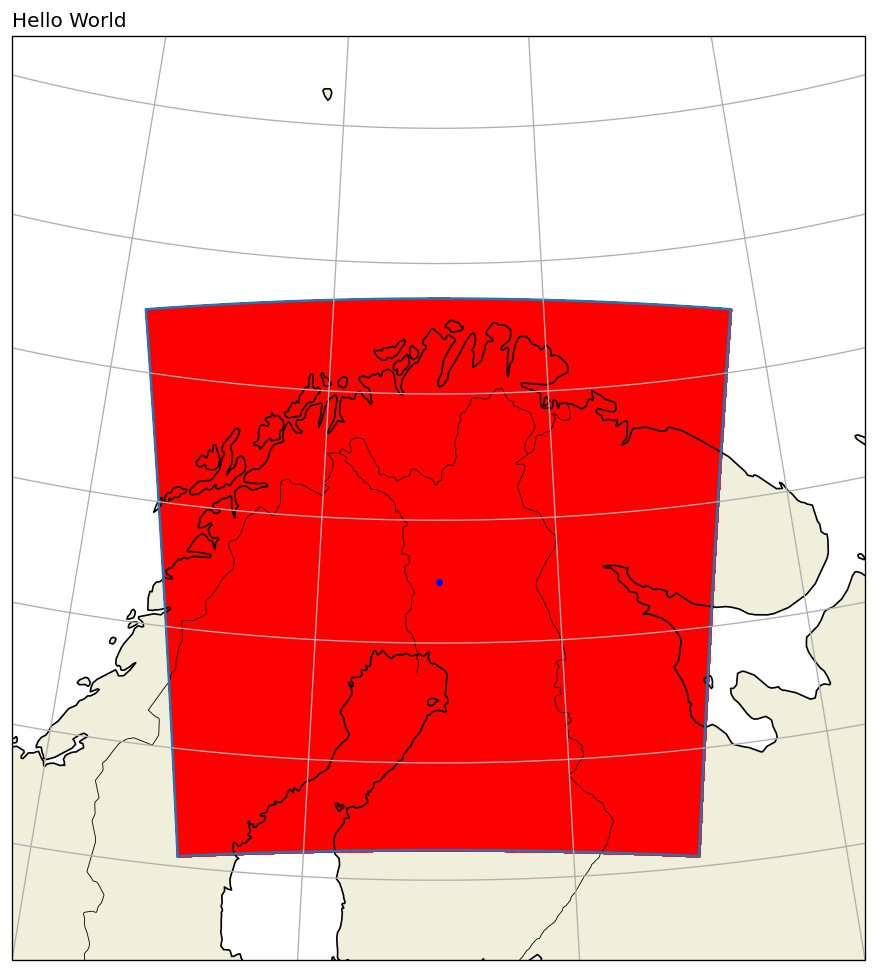

In [221]:
p = ccrs.LambertConformal(
    central_latitude = 60.,
    central_longitude = 25.)

p2 = ccrs.Stereographic(
    central_latitude = 65.,
    central_longitude = 25.)
fig = plt.figure(figsize=(10,10), dpi=120)
ax = plt.axes(projection=p)
#ax.coastlines()
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cf.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cf.LAND)
ax.add_feature(cf.COASTLINE)
ax.add_feature(states_provinces, edgecolor='k', lw=0.5)
ax.set_extent([10., 40., 60., 75.])
ax.gridlines()
ax.scatter(lon, lat, transform=ccrs.PlateCarree(), c='red', s=0.1)
ax.plot(get_array_edge(lon), get_array_edge(lat), transform=ccrs.PlateCarree())
ax.scatter(center_lon, center_lat, transform=ccrs.PlateCarree(), c='blue', s=10.)
plt.title('Hello World', loc='left')
#ax.text(7., 47., 'hello', transform=ccrs.PlateCarree())
plt.show()

In [89]:
ax.get_data_ratio()

0.9779540793184995

In [168]:
import regionsns
import importlib

In [180]:
importlib.reload(regions)
region = regions.Region("Finland")
region.subdomains

{'Default': {'name': 'Default',
  'lon': array([[58.40870156, 58.40916051, 58.40961716, ..., 58.41007153,
          58.40961716, 58.40916051],
         [58.41766406, 58.41812315, 58.41857994, ..., 58.41903444,
          58.41857994, 58.41812315],
         [58.42662656, 58.42708578, 58.42754271, ..., 58.42799735,
          58.42754271, 58.42708578],
         ...,
         [61.96547463, 61.96599488, 61.96651253, ..., 61.96702758,
          61.96651253, 61.96599488],
         [61.97442733, 61.97494775, 61.97546558, ..., 61.9759808 ,
          61.97546558, 61.97494775],
         [61.98337999, 61.98390058, 61.98441857, ..., 61.98493397,
          61.98441857, 61.98390058]]),
  'lat': array([[21.57804764, 21.59512499, 21.61220282, ..., 28.37071886,
          28.38779718, 28.40487501],
         [21.57717073, 21.59425244, 21.61133463, ..., 28.37158269,
          28.38866537, 28.40574756],
         [21.57629334, 21.59337941, 21.61046596, ..., 28.372447  ,
          28.38953404, 28.40662059],
  

In [487]:
def change_stuff(some_list):
    some_list[3]["hello"] = "hello"

def some_other_change(some_dict):
    some_dict["wtf"] = "WTF?"
some_list = [{}, {}, {}, {}]
change_stuff(some_list)
some_other_change(some_list[1])
some_list

[{}, {'wtf': 'WTF?'}, {}, {'hello': 'hello'}]

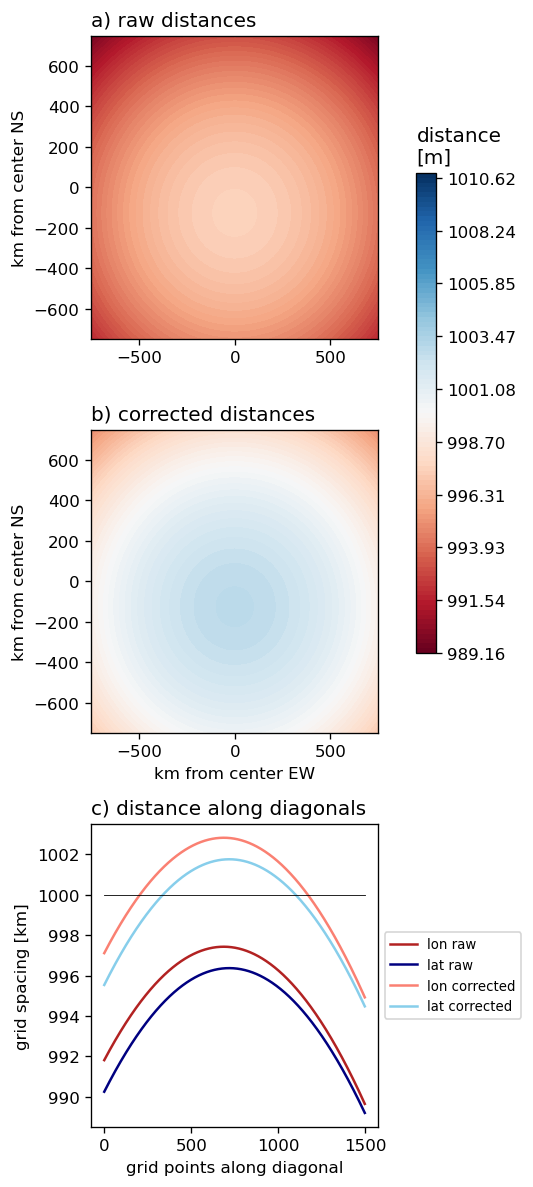

In [504]:
fig, ax = plt.subplots(3,1, figsize=(4,10), dpi=120)

lev_limit = np.max(np.abs(np.array([dist_min_global - d, dist_max_global - d])))
d_lev = 2 * lev_limit / 100.
levels = 1000. * np.arange(d - lev_limit, d + lev_limit + 0.01 * d_lev, d_lev)

idx_long = d * np.array(range(int(-nx/2), int(nx/2)))
idx_shor = d * np.array(range(int(-nx/2+1), int(nx/2-1)))

c1 = ax[0].contourf(idx_long, idx_shor, 1000. * distance11, levels=levels, cmap="RdBu")
c3 = ax[1].contourf(idx_long, idx_shor, 1000. * distance21, levels=levels, cmap="RdBu")
ax[0].set_title("a) raw distances".format(np.mean(distance11)), loc='left')
ax[1].set_title("b) corrected distances".format(np.mean(distance21)), loc='left')
ax[0].set_ylabel("km from center NS")
ax[1].set_ylabel("km from center NS")
ax[1].set_xlabel("km from center EW")

diag = np.zeros((4, int(nx-2)))
for ii in range(int(nx-2)):
    diag[0, ii] = 1000. * distance11[ii, ii]
    diag[1, ii] = 1000. * distance12[ii, ii]
    diag[2, ii] = 1000. * distance21[ii, ii]
    diag[3, ii] = 1000. * distance22[ii, ii]

xlen = diag.shape[1]
ax[2].plot(diag[0, :], color = "firebrick", label="lon raw")
ax[2].plot(diag[1, :], color = "navy", label="lat raw")
ax[2].plot(diag[2, :], color = "salmon", label="lon corrected")
ax[2].plot(diag[3, :], color = "skyblue", label="lat corrected")
ax[2].plot([0., xlen], [1000. * d, 1000. * d], 'k', lw=0.5)

ax[2].set_title("c) distance along diagonals", loc="left")
ax[2].set_xlabel("grid points along diagonal")
ax[2].set_ylabel("grid spacing [km]")
plt.tight_layout()

ax[2].legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1., 0.5))
fig.subplots_adjust(right=0.8)
cax = fig.add_axes([0.88, 0.45, 0.04, 0.4])
plt.colorbar(c1, cax=cax)
cax.set_title('distance\n[m]', loc='left')
plt.show()
plt.close('all')